In [15]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm
from matplotlib.widgets import Slider, Button

import astropy.units as u
import astropy.constants as const
from astropy.time import Time
from astropy.coordinates import EarthLocation, Angle

from scipy.signal.windows import tukey


import time as timer
import sys, os
sys.path.append(os.path.abspath(".."))
from interactions_funcs import *

%matplotlib nbagg

In [16]:
from screens.screen import Source, Screen1D, Telescope
from screens.fields import phasor
from screens.visualization import axis_extent

## Load pulsar params

In [3]:
#distance
d_p = 620. * u.pc
PMRA = 2.2 * u.mas / u.year
PMDEC = 51.6 * u.mas / u.year


#observation params
mjds = 53295.
psrname = 'PSRB0834+06'
telescope =  EarthLocation(2390487.080, -5564731.357, 1994720.633, unit="m") #AO


#frequency
freq0 = 400
freq = np.linspace(freq0 - 2, freq0 + 2, 1024) * u.MHz


#earth terms
vtel_vec = get_vearth(psrname, mjds) 
vearth = np.sqrt( np.dot(vtel_vec, vtel_vec ) )
e_angle = np.arctan2(vtel_vec[1] , vtel_vec[0]).to(u.deg)

#pulsar terms
vpsr_init = ( d_p * np.sqrt( PMDEC**2 + PMRA**2)  / u.rad ).to(u.km / u.s)
dp_angle_init = np.arctan2( PMDEC , PMRA ).to(u.deg)

## insert screen params

In [4]:
d_s1_init = 390 * u.pc 
xi1_init = 153.*u.deg 
v1_init = 23*u.km/u.s 


#distance, orientaiton and velocity
d_s2_init = 420 * u.pc 
xi2_init = 137. *u.deg 
v2_init =  -3 *u.km/u.s 


<IPython.core.display.Javascript object>


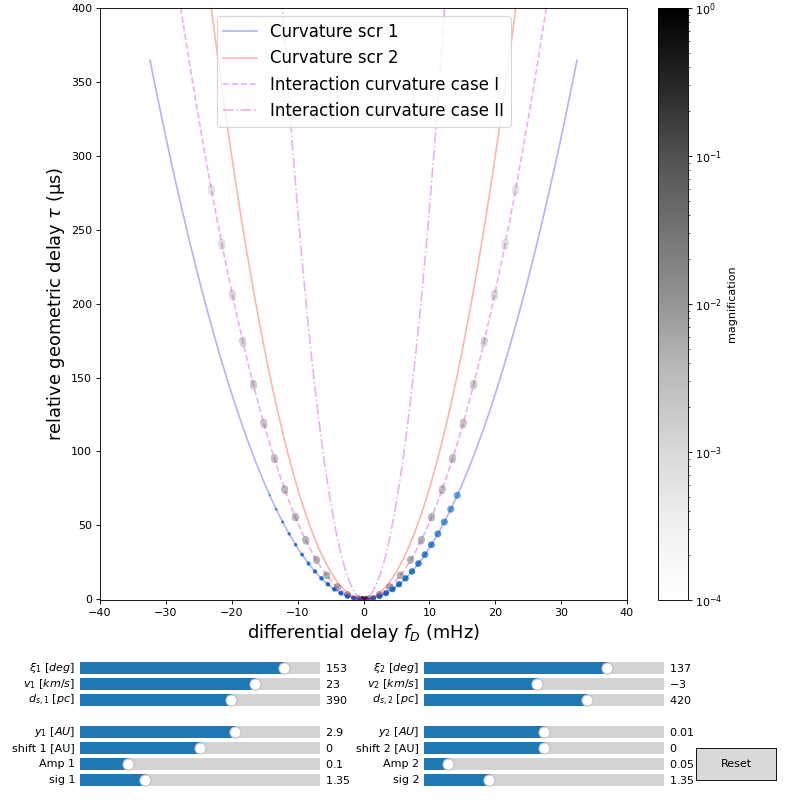

0

In [9]:
%matplotlib nbagg

#number of points for screen 1 and screen 2
N1 = 30
N2 = 30

#initial shift of the points in AU 
shift1_init = 0.
shift2_init = 0.

#unit variables
tau_unit = u.us
taudot_unit = u.us/u.day

#scale factors that control the physical scale of the 1d screens
#they are just multipliers applied to the scales of 1AU 1d screens
#for instance scr2_init = 0.1 implies the screen spans -0.1 AU to 0.1 AU

scr1_init = 2.9
scr2_init = 0.01

# scr1_init = 0.1
# scr2_init = 3.0

# scr1_init = 4.1
# scr2_init = 0.05


taudot_arr = np.linspace(-7,7,200) * u.us * u.day**-1

#amplitudes and sigma
Amp1_init = 0.1
Amp2_init = 0.113
Amp2_init = 0.05

# Amp1_init = 0.1
# Amp2_init = 0.01


sig1_init = 1.35
sig2_init = 1.35


fd_max = 40
tau_max = 400



#getting a curvature for the first screen
eta1, ddeff1, dveff1 = screen_1d_curvature(d_p = d_p, 
                    vpsr = vpsr_init, 
                    dp_angle = dp_angle_init, 
                    vearth = vearth, 
                    e_angle = e_angle, 
                    ds1 = d_s1_init, 
                    xi1 = xi1_init, 
                    v1 = v1_init, 
                    freq = np.mean(freq),
                    extra_info = True)


#getting a curvature for the second screen
eta2, ddeff2, dveff2 = screen_1d_curvature(d_p = d_p, 
                    vpsr = vpsr_init, 
                    dp_angle = dp_angle_init, 
                    vearth = vearth, 
                    e_angle = e_angle, 
                    ds1 = d_s2_init, 
                    xi1 = xi2_init, 
                    v1 = v2_init, 
                    freq = np.mean(freq),
                    extra_info = True)


eta_int1, eta_int2, _, _, diveff1, diveff2  = interaction_arcs(d_p = d_p, 
                                        vpsr = vpsr_init, 
                                        dp_angle = dp_angle_init, 
                                        vearth = vearth, 
                                        e_angle = e_angle, 
                                        ds1 = d_s1_init, 
                                        xi1 = xi1_init, 
                                        v1 = v1_init, 
                                        ds2 = d_s2_init, 
                                        xi2 = xi2_init, 
                                        v2 = v2_init, 
                                        freq = np.mean(freq))




#Getting details of the scattering geometry, where 
#obs0: line of sight path
#obs1: pulsar -> screen 1 -> Earth
#obs2: pulsar -> screen 2 -> Earth
#Obs12: pulsar -> screen 2 -> screen 1 -> Earth
obs0, obs1, obs2, obs12, los_fac = observations(xi1=xi1_init, v1=v1_init,
                                                 xi2=xi2_init, v2=v2_init,
                                                 vpsr=vpsr_init, dp_angle=dp_angle_init,
                                                 scr1_scale = scr1_init, scr2_scale = scr2_init,
                                                 d_s1 = d_s1_init, d_s2 = d_s2_init, 
                                                 Amp1 = Amp1_init, Amp2 = Amp2_init,
                                                 sig1 = sig1_init, sig2 = sig2_init,
                                                 shift1 = shift1_init, shift2 = shift2_init,
                                                 N1 = N1, N2 = N2,
                                                 d_p = d_p, vearth = vearth, e_angle = e_angle
                                               )
all_obs = obs0, obs1, obs2, obs12
brightness = np.hstack([obs.brightness.ravel() * los_fac for obs in all_obs])
mall = np.abs(brightness)
# assert np.isclose(np.sum(np.abs(brightness)**2), 1.)

fig, ax = plt.subplots(figsize=(10., 10.), dpi = 100)
    

scs = []
npoints = obs1.tau.shape[0]
#Adjust the sizes of the points on screen 1 (only to identify where each double scattered image comes from)
sizes = np.linspace(1, 30, npoints)  # 30 → 5, adjust as you like



for obs, marker, cmap in (
        (obs0, "x", "Greys"),
        (obs1, "o", "Blues"),
        (obs2, "o", "Reds"),
        (obs12, "o", "Greys"))[::-1]:

    tau = obs.tau.to_value(tau_unit).ravel()
    taudot = obs.taudot.to_value(taudot_unit).ravel() * (
        u.us * u.day**-1 * np.mean(freq)
    ).to(u.mHz).value

    if obs is obs1:
        # assign one size per obs1 point
        point_sizes = sizes
    elif obs is obs12:
        # repeat each obs1 size for the 10 points in obs12
        tau = tau
        taudot = taudot
        
#         point_sizes = np.repeat(sizes, obs.tau.shape[1])  # shape (60*10,)
        point_sizes = 20
        sc = ax.scatter(taudot, tau, marker=marker, s=point_sizes,
                    c=np.abs(obs.brightness).ravel(), cmap=cmap,
                    norm=LogNorm(vmin=1e-4, vmax=1))
    else:
        # constant size for other obs
        point_sizes = 20
        
    if obs != obs12:
        sc = ax.scatter(taudot, tau, marker=marker, s=point_sizes,
                    c=np.abs(obs.brightness).ravel(), cmap=cmap,
                    norm=LogNorm(vmin=1e-4, vmax=1))
    
    
    scs.insert(0, sc)


fig.colorbar(mappable=sc, label="magnification", fraction=0.1)

ax.set_xlabel(rf"differential delay $f_D$ (mHz)", fontsize = 16)
ax.set_ylabel(rf"relative geometric delay $\tau$ ({tau_unit:latex_inline})", fontsize = 16)

line1, = ax.plot(( taudot_arr * np.mean(freq) ).to(u.mHz) , (( taudot_arr * np.mean(freq) ).to(u.mHz)**2 * eta1).to(u.us), c = 'b', alpha = 0.3 , label = 'Curvature scr 1')
line2, = ax.plot(( taudot_arr * np.mean(freq) ).to(u.mHz) , (( taudot_arr * np.mean(freq) ).to(u.mHz)**2 * eta2).to(u.us), c = 'r', alpha = 0.3 , label = 'Curvature scr 2')

#interaction arc curvature for case I
line3, = ax.plot(( taudot_arr * np.mean(freq) ).to(u.mHz) , (( taudot_arr * np.mean(freq) ).to(u.mHz)**2 * eta_int1).to(u.us), '--' ,c = 'm', alpha = 0.3, label = 'Interaction curvature case I'  )
#interaction arc curvature for case II
line4, = ax.plot(( taudot_arr * np.mean(freq) ).to(u.mHz) , (( taudot_arr * np.mean(freq) ).to(u.mHz)**2 * eta_int2).to(u.us), '-.' ,c = 'm', alpha = 0.3, label = 'Interaction curvature case II'  )



ax.set_ylim(-0.5,tau_max)
ax.set_xlim(-fd_max,fd_max)
ax.legend(fontsize = 15)

# adjust the main plot to make room for the sliders
fig.subplots_adjust(bottom = 0.25, top = 0.99)
# Make a horizontal slider to control the frequency.


dy = -0.05


ax_xi1 = fig.add_axes([0.1, 0.2 + dy , 0.3, 0.03])
xi1_slider = Slider(ax=ax_xi1, label=r'$\xi_{1}~[deg]$',
                    valmin=0., valmax=180, valinit=xi1_init.to_value(u.deg))

ax_xi2 = fig.add_axes([0.53, 0.2 + dy , 0.3, 0.03])
xi2_slider = Slider(ax=ax_xi2, label=r'$\xi_{2}~[deg]$',
                    valmin=0., valmax=180, valinit=xi2_init.to_value(u.deg))


ax_v1 = fig.add_axes([0.1, 0.18 + dy , 0.3, 0.03])
v1_slider = Slider(ax=ax_v1, label=r'$v_{1}~[km/s]$',
                   valmin=-50., valmax=50, valinit=v1_init.value)

ax_v2 = fig.add_axes([0.53, 0.18 + dy , 0.3, 0.03])
v2_slider = Slider(ax=ax_v2, label=r'$v_{2}~[km/s]$',
                   valmin=-50., valmax=50, valinit=v2_init.value)


ax_ds1 = fig.add_axes([0.1, 0.16 + dy , 0.3, 0.03])
ds1_slider = Slider(ax=ax_ds1, label=r'$d_{s,1}~[pc]$',
                     valmin=0., valmax=d_p.value, valinit=d_s1_init.to_value(u.pc))

ax_ds2 = fig.add_axes([0.53, 0.16 + dy , 0.3, 0.03])
ds2_slider = Slider(ax=ax_ds2, label=r'$d_{s,2}~[pc]$',
                     valmin=0., valmax=d_p.value, valinit=d_s2_init.to_value(u.pc))




ax_scr1 = fig.add_axes([0.1, 0.12 + dy , 0.3, 0.03])
scr1_slider = Slider(ax=ax_scr1, label=r'$y_1~[AU]$',
                     valmin=-10., valmax=10, valinit=scr1_init)

ax_scr2 = fig.add_axes([0.53, 0.12 + dy , 0.3, 0.03])
scr2_slider = Slider(ax=ax_scr2, label=r'$y_2~[AU]$',
                     valmin=-10., valmax=10., valinit=scr2_init)

ax_shift1 = fig.add_axes([0.1, 0.10 + dy, 0.3, 0.03])
shift1_slider = Slider(ax=ax_shift1, label=r'shift 1 [AU]',
                     valmin=-10., valmax=10, valinit=shift1_init)

ax_shift2 = fig.add_axes([0.53, 0.10 + dy, 0.3, 0.03])
shift2_slider = Slider(ax=ax_shift2, label=r'shift 2 [AU]',
                     valmin=-10., valmax=10, valinit=shift2_init)

ax_Amp1 = fig.add_axes([0.1, 0.08 + dy , 0.3, 0.03])
amp1_slider = Slider(ax=ax_Amp1, label=r'Amp 1',
                     valmin=0., valmax=0.5, valinit=Amp1_init)

ax_Amp2 = fig.add_axes([0.53, 0.08 + dy, 0.3, 0.03])
amp2_slider = Slider(ax=ax_Amp2, label=r'Amp 2',
                     valmin=0., valmax=0.5, valinit=Amp2_init)

ax_sig1 = fig.add_axes([0.1, 0.06  + dy, 0.3, 0.03])
sig1_slider = Slider(ax=ax_sig1, label=r'sig 1',
                     valmin=0., valmax=5, valinit=sig1_init)

ax_sig2 = fig.add_axes([0.53, 0.06 + dy, 0.3, 0.03])
sig2_slider = Slider(ax=ax_sig2, label=r'sig 2',
                     valmin=0., valmax=5, valinit=sig2_init)






def update(val):
    obs0, obs1, obs2, obs12, los_fac = observations(
        xi1=xi1_slider.val * u.deg,
        v1=v1_slider.val * u.km/u.s,
        xi2 = xi2_slider.val * u.deg,
        v2 = v2_slider.val * u.km/u.s,
        vpsr = vpsr_init,
        dp_angle = dp_angle_init,
        scr1_scale = scr1_slider.val,
        scr2_scale = scr2_slider.val,
        d_s1 = ds1_slider.val * u.pc,
        d_s2 = ds2_slider.val * u.pc,
        Amp1 = amp1_slider.val,
        Amp2 = amp2_slider.val,
        sig1 = sig1_slider.val,
        sig2 = sig2_slider.val,
        shift1 = shift1_slider.val,
        shift2 = shift2_slider.val,
        N1 = N1, N2 = N2,
        d_p = d_p, vearth = vearth, e_angle = e_angle
        )
    

    all_obs = obs0, obs1, obs2, obs12
    brightnesses = [obs.brightness.ravel() * los_fac for obs in all_obs]
    
    
    for obs, sc, b in zip(all_obs, scs, brightnesses):
        tau = obs.tau.to_value(tau_unit).ravel()
        taudot = obs.taudot.to_value(taudot_unit).ravel() * (u.us * u.day**-1 * np.mean(freq)).to(u.mHz).value
        
        sc.set_offsets(np.vstack([taudot, tau]).T)

#         Update color intensities
        sc.set_array(np.abs(b.ravel()))  # brightness is already scaled by los_fac
    
    
        
    eta1_new = screen_1d_curvature(d_p = d_p, 
                    vpsr = vpsr_init, 
                    dp_angle = dp_angle_init, 
                    vearth = vearth, 
                    e_angle = e_angle, 
                    ds1 = ds1_slider.val * u.pc, 
                    xi1 = xi1_slider.val * u.deg, 
                    v1 = v1_slider.val * u.km/u.s, 
                    freq = np.mean(freq))
    
    eta2_new = screen_1d_curvature(d_p = d_p, 
                    vpsr = vpsr_init, 
                    dp_angle = dp_angle_init, 
                    vearth = vearth, 
                    e_angle = e_angle, 
                    ds1 = ds2_slider.val * u.pc, 
                    xi1 = xi2_slider.val * u.deg, 
                    v1 = v2_slider.val * u.km/u.s, 
                    freq = np.mean(freq))
    
    
    eta_int1_new, eta_int2_new, _, _, _, _  = interaction_arcs(d_p = d_p, 
                                        vpsr = vpsr_init, 
                                        dp_angle = dp_angle_init, 
                                        vearth = vearth, 
                                        e_angle = e_angle, 
                                        ds1 = ds1_slider.val * u.pc, 
                                        xi1 = xi1_slider.val * u.deg, 
                                        v1 = v1_slider.val * u.km/u.s, 
                                        ds2 = ds2_slider.val * u.pc, 
                                        xi2 = xi2_slider.val * u.deg, 
                                        v2 = v2_slider.val * u.km/u.s, 
                                        freq = np.mean(freq))
        
        
        
    line1.set_ydata((( taudot_arr * np.mean(freq) ).to(u.mHz)**2 * eta1_new).to(u.us))
    line2.set_ydata((( taudot_arr * np.mean(freq) ).to(u.mHz)**2 * eta2_new).to(u.us))
    line3.set_ydata((( taudot_arr * np.mean(freq) ).to(u.mHz)**2 * eta_int1_new).to(u.us))
    line4.set_ydata((( taudot_arr * np.mean(freq) ).to(u.mHz)**2 * eta_int2_new).to(u.us))




xi1_slider.on_changed(update)
v1_slider.on_changed(update)
xi2_slider.on_changed(update)
v2_slider.on_changed(update)
scr1_slider.on_changed(update)
scr2_slider.on_changed(update)
ds1_slider.on_changed(update)
ds2_slider.on_changed(update)
amp1_slider.on_changed(update)
amp2_slider.on_changed(update)
sig1_slider.on_changed(update)
sig2_slider.on_changed(update)
shift1_slider.on_changed(update)
shift2_slider.on_changed(update)


resetax = fig.add_axes([0.87, 0.025, 0.1, 0.04])
button = Button(resetax, 'Reset', hovercolor='0.975')

def reset(event):
    xi1_slider.reset()
    v1_slider.reset()
    xi2_slider.reset()
    v2_slider.reset()
    vpsr_slider.reset()
    vpa_slider.reset()
    scr1_slider.reset()
    scr2_slider.reset()
    ds1_slider.reset()
    ds2_slider.reset()
    amp1_slider.reset()
    amp2_slider.reset()
    sig1_slider.reset()
    sig2_slider.reset()
    shift1_slider.reset()
    shift2_slider.reset()

button.on_clicked(reset)

In [6]:
%matplotlib inline

## Phase gradients for screen 1 and case I 

In [13]:
#distance
d_p = 620. * u.pc
PMRA = 2.2 * u.mas / u.year
PMDEC = 51.6 * u.mas / u.year


#observation params
mjds = 53295.
psrname = 'PSRB0834+06'
telescope =  EarthLocation(2390487.080, -5564731.357, 1994720.633, unit="m") #AO


#frequency
freq0 = 400
freq_band = 1
freq = np.linspace(freq0 - freq_band, freq0 + freq_band, 1024) * u.MHz

#time array (hour observation)
ts = np.linspace(0, 1, 600)/24
time = Time(53295., ts, format="mjd")

# Locations from PINT: src/pint/observatory/observatories.py
dishes = {
    "AO": EarthLocation(2390487.080, -5564731.357, 1994720.633, unit="m"),
    "GB" : EarthLocation(882589.289, -4924872.368, 3943729.418, unit="m"),
}

#earth terms
vtel_vec = get_vearth(psrname, mjds) 
vearth = np.sqrt( np.dot(vtel_vec, vtel_vec ) )
e_angle = np.arctan2(vtel_vec[1] , vtel_vec[0]).to(u.deg)

#pulsar terms
vpsr_init = ( d_p * np.sqrt( PMDEC**2 + PMRA**2)  / u.rad ).to(u.km / u.s)
dp_angle_init = np.arctan2( PMDEC , PMRA ).to(u.deg)

In [17]:
timer2 = timer.time()

#set the pulsar position, distance, proper motion, as well as velocity and orientation on the sky
pulsar_params = "8h37m05.6485930s", "6d10m16.06361s", d_p, PMRA, PMDEC, vpsr_init, dp_angle_init 

#set screen 1 and screen 2 distance, orientation and velocity
scr1_params = d_s1_init, xi1_init, v1_init 
scr2_params = d_s2_init, xi2_init, v2_init 


obs0, obs1, obs2, obs12, los_fac = observations(xi1=xi1_init, v1=v1_init,
                                                 xi2=xi2_init, v2=v2_init,
                                                 vpsr=vpsr_init, dp_angle=dp_angle_init,
                                                 scr1_scale = scr1_init, scr2_scale = scr2_init,
                                                 d_s1 = d_s1_init, d_s2 = d_s2_init, 
                                                 Amp1 = Amp1_init, Amp2 = Amp2_init,
                                                 sig1 = sig1_init, sig2 = sig2_init,
                                                 shift1 = shift1_init, shift2 = shift2_init,
                                                 N1 = N1, N2 = N2,
                                                 d_p = d_p, vearth = vearth, e_angle = e_angle
                                               )
all_obs = obs0, obs1, obs2, obs12
brightness = np.hstack([obs.brightness.ravel() * los_fac for obs in all_obs])
mall = np.abs(brightness)

#compute the visibilities, and baselines
spectra, uvw, wavefields = int_vlbi(pulsar_params, 
                                       time, freq, dishes,
                                       scr1_params,
                                         scr2_params,
                                         N1 = N1, N2 = N2,
                                         Amp1 = Amp1_init, Amp2 = Amp2_init,
                                         sig1 = sig1_init, sig2 = sig2_init,
                                         scr1_scale = scr1_init, scr2_scale = scr2_init,
                                         shift1 = shift1_init, shift2 = shift2_init, los_fac = los_fac, mag_mult = 1.)

print('Time: ', timer.time() - timer2)


#compute geometric factors related to the 2-screen geometry
deff_int_1, deff_int_2, veff_int_1, veff_int_2, sig1, sig2, gam1, gam2  = interaction_geometric_factors(d_p = d_p, 
                                        vpsr = vpsr_init, 
                                        dp_angle = dp_angle_init, 
                                        vearth = vearth, 
                                        e_angle = e_angle, 
                                        ds1 = d_s1_init, 
                                        xi1 = xi1_init, 
                                        v1 = v1_init, 
                                        ds2 = d_s2_init, 
                                        xi2 = xi2_init, 
                                        v2 = v2_init, 
                                        freq = np.mean(freq))

#getting a curvature for the first screen
eta1, ddeff1, dveff1 = screen_1d_curvature(d_p = d_p, 
                    vpsr = vpsr_init, 
                    dp_angle = dp_angle_init, 
                    vearth = vearth, 
                    e_angle = e_angle, 
                    ds1 = d_s1_init, 
                    xi1 = xi1_init, 
                    v1 = v1_init, 
                    freq = np.mean(freq),
                    extra_info = True)


#getting a curvature for the second screen
eta2, ddeff2, dveff2 = screen_1d_curvature(d_p = d_p, 
                    vpsr = vpsr_init, 
                    dp_angle = dp_angle_init, 
                    vearth = vearth, 
                    e_angle = e_angle, 
                    ds1 = d_s2_init, 
                    xi1 = xi2_init, 
                    v1 = v2_init, 
                    freq = np.mean(freq),
                    extra_info = True)

#compute curvatures for case i and ii 
eta_int1, eta_int2, _, _, diveff1, diveff2  = interaction_arcs(d_p = d_p, 
                                        vpsr = vpsr_init, 
                                        dp_angle = dp_angle_init, 
                                        vearth = vearth, 
                                        e_angle = e_angle, 
                                        ds1 = d_s1_init, 
                                        xi1 = xi1_init, 
                                        v1 = v1_init, 
                                        ds2 = d_s2_init, 
                                        xi2 = xi2_init, 
                                        v2 = v2_init, 
                                        freq = np.mean(freq))

Time:  19.663801431655884


<IPython.core.display.Javascript object>


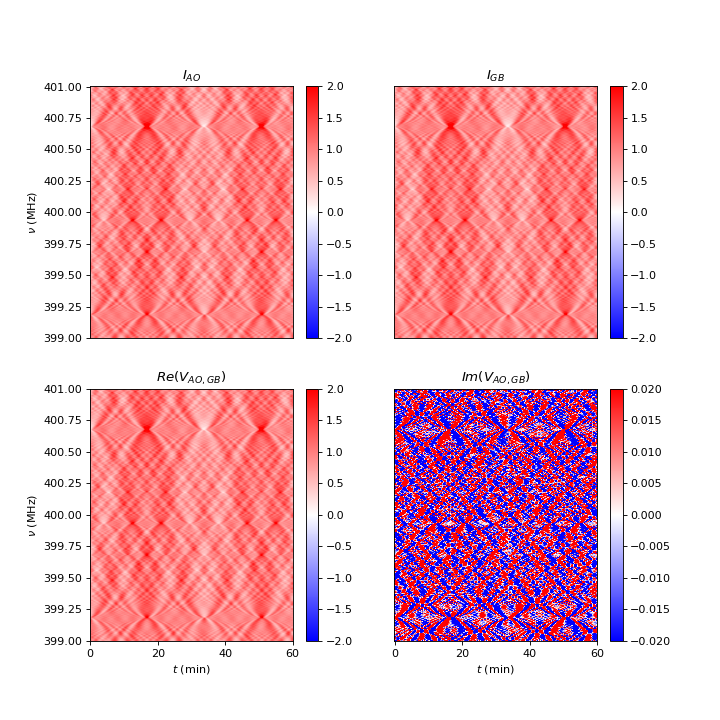

In [18]:
names = list(dishes)

disp_lim = 2.

imshow_kwargs = dict(origin='lower', aspect='auto', cmap='bwr',
                     extent=axis_extent((time-time[0]).to(u.min), freq))

grid = plt.GridSpec(nrows=2, ncols=2)
plt.figure(figsize=(9, 9))


for i in range(2):
    plt.subplot(grid[0, i])
    plt.imshow(spectra[names[i], names[i]].real / np.mean(np.abs(spectra[names[i], names[i]])), 
               vmin=-disp_lim, vmax=disp_lim, **imshow_kwargs)
    plt.xticks([])
    plt.title(rf'$I_{{{names[i]}}}$')
    plt.colorbar()
    if i<1:
        plt.ylabel(r'$\nu~\left(\rm{MHz}\right)$')
    else:
        plt.yticks([])
    
    
for i in range(2):
    plt.subplot(grid[1, i])
    
    if i ==0:
        spec = spectra[names[0], names[1]].real / np.mean(spectra[names[0], names[1]].real)
        mult = 1.
        plt.ylabel(r'$\nu~\left(\rm{MHz}\right)$')
        plt.title(rf'$Re\left(V_{{{names[0]},{names[1]}}}\right)$')
        
    else:
        spec = spectra[names[0], names[1]].imag  
        mult = 1e-2
        plt.yticks([])
        plt.title(rf'$Im\left(V_{{{names[0]},{names[1]}}}\right)$')
        
    plt.imshow(spec, 
               vmin=-disp_lim*mult, vmax=disp_lim*mult, **imshow_kwargs)

    plt.xlabel(r'$t~\left(\rm{min}\right)$')
    
    plt.colorbar()

<IPython.core.display.Javascript object>


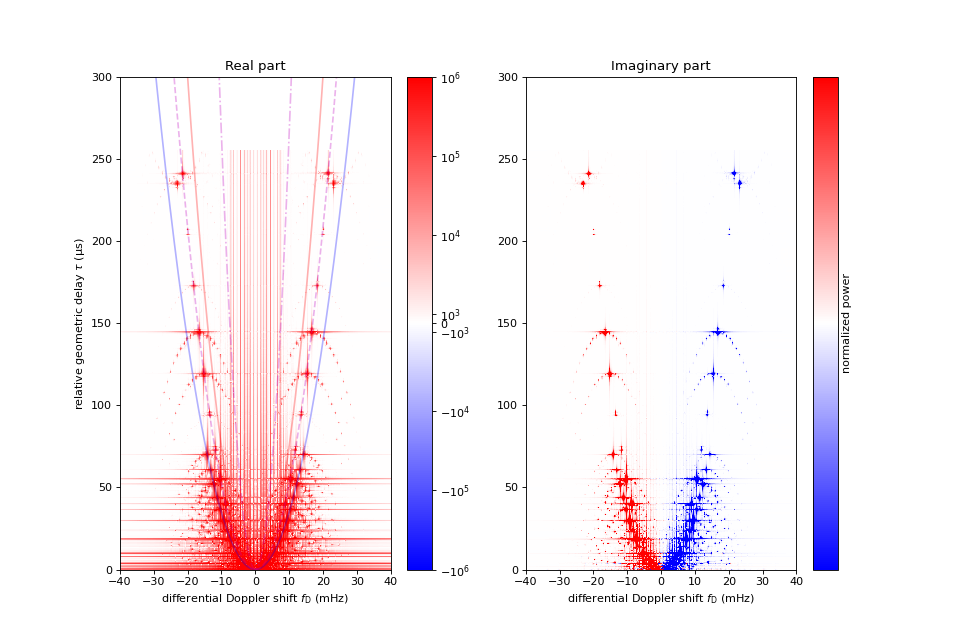

In [19]:
conjspec00 = np.fft.fftshift(np.fft.fft2(spectra[names[0], names[1]]))
conjspec11 = np.roll(np.roll(np.fliplr(np.flipud(conjspec00)),1,0),1,1)



cs0 = np.fft.fftshift(np.fft.fft2(spectra[names[0], names[0]].real -spectra[names[0], names[0]].real.mean()))
cs1 = np.fft.fftshift(np.fft.fft2(spectra[names[1], names[1]].real -spectra[names[1], names[1]].real.mean()))
ccs = cs0*np.conjugate(cs1)

tau = np.fft.fftshift(np.fft.fftfreq(freq.size, freq[1]-freq[0])).to(u.us)
fd = np.fft.fftshift(np.fft.fftfreq((time-time[0]).to(u.min).size, 
                                    (time-time[0]).to(u.min)[1]-(time-time[0]).to(u.min)[0])).to(u.mHz)


ylimit = 300
xlimit = 40


plt.figure(  figsize=(12., 8.)  )


plt.subplot(121)
plt.imshow( np.real( ccs ),
           origin='lower', aspect='auto', interpolation='none',
           extent=axis_extent(fd, tau), cmap='bwr',
           norm=SymLogNorm(vmin=-1e6, vmax=1e6, linthresh = 1e4))

# plt.xlim(-20., 20.)
# plt.ylim(0., 40.)
plt.xlabel(r"differential Doppler shift $f_\mathrm{{D}}$ "
           rf"({fd.unit.to_string('latex')})")
plt.ylabel(r"relative geometric delay $\tau$ "
           rf"({tau.unit.to_string('latex')})")


cbar = plt.colorbar()
plt.title('Real part')

plt.plot(( taudot_arr * np.mean(freq) ).to(u.mHz) , (( taudot_arr * np.mean(freq) ).to(u.mHz)**2 * eta1).to(u.us), c = 'b', alpha = 0.3 , label = 'Curvature scr 1')
plt.plot(( taudot_arr * np.mean(freq) ).to(u.mHz) , (( taudot_arr * np.mean(freq) ).to(u.mHz)**2 * eta2).to(u.us), c = 'r', alpha = 0.3 , label = 'Curvature scr 2')

#interaction arc curvature for case I
plt.plot(( taudot_arr * np.mean(freq) ).to(u.mHz) , (( taudot_arr * np.mean(freq) ).to(u.mHz)**2 * eta_int1).to(u.us), '--' ,c = 'm', alpha = 0.3, label = 'Interaction curvature case I'  )
#interaction arc curvature for case II
plt.plot(( taudot_arr * np.mean(freq) ).to(u.mHz) , (( taudot_arr * np.mean(freq) ).to(u.mHz)**2 * eta_int2).to(u.us), '-.' ,c = 'm', alpha = 0.3, label = 'Interaction curvature case II'  )





plt.ylim(-0.,ylimit)
plt.xlim(-xlimit,xlimit)



plt.subplot(122)


plt.imshow( np.imag( ccs ),
           origin='lower', aspect='auto', interpolation='none',
           extent=axis_extent(fd, tau), cmap='bwr',
           norm=SymLogNorm(vmin=-1e5, vmax=1e5, linthresh = 1e5))

# plt.xlim(-20., 20.)
# plt.ylim(0., 40.)
plt.xlabel(r"differential Doppler shift $f_\mathrm{{D}}$ "
           rf"({fd.unit.to_string('latex')})")
plt.title('Imaginary part')

cbar = plt.colorbar()
cbar.set_label('normalized power')

plt.ylim(-0.,ylimit)
plt.xlim(-xlimit,xlimit)

plt.show()

## Phase gradient for screen 1

/cita/modules/python/3.10.2/lib/python3.10/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


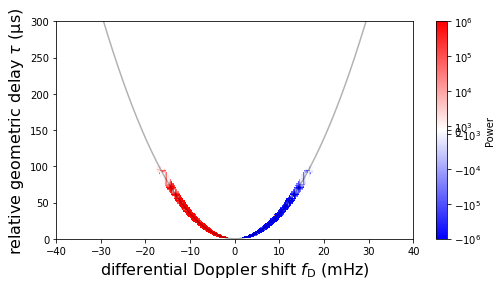

/tmp/ipykernel_2612671/1203081101.py:50: RuntimeWarning: Mean of empty slice
  r1 = np.nanmean(np.real( ccs )[np.where(tau >= 0)]*mask1[np.where(tau >= 0)],axis=0)
/tmp/ipykernel_2612671/1203081101.py:51: RuntimeWarning: Mean of empty slice
  i1 = np.nanmean(np.imag( ccs )[np.where(tau >= 0)]*mask1[np.where(tau >= 0)],axis=0)


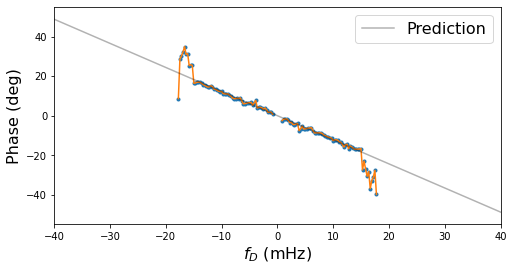

In [21]:


tau_tol = 1.
tau_sel_max = 100
tau_sel_min = 0.9

ylimit = 300
xlimit = 40

#put an orientation, curvature and veff for the prediction
screenOrientation = xi1_slider.val*u.deg 
eta = eta1
vveff = dveff1


#make a mask to get a phase gradient surrounding the curvature value
grid = np.meshgrid(fd,tau)
mask1 = np.ones(grid[0].shape)
mask1[np.sqrt(grid[1]/eta)<np.abs(grid[0])-tau_tol*u.mHz] = np.nan
mask1[np.sqrt(grid[1]/eta)>np.abs(grid[0])+tau_tol*u.mHz] = np.nan
mask1[np.abs(grid[1]) > tau_sel_max * u.us] = np.nan
mask1[np.abs(grid[1]) < tau_sel_min * u.us] = np.nan
#mask cross spectrum
masked_A = np.ma.masked_invalid(np.angle( ccs ) * 180 / np.pi * mask1)

plt.figure(  figsize=(8., 4.)  )

plt.imshow( masked_A  * np.real(ccs) ,
           origin='lower', aspect='auto', interpolation='none',
           cmap = 'bwr',
           extent=axis_extent(fd, tau),
           norm=SymLogNorm(vmin=-1e6, vmax=1e6, linthresh = 1e4))

plt.xlim(-xlimit, xlimit)
plt.ylim(0., ylimit)
plt.xlabel(r"differential Doppler shift $f_\mathrm{{D}}$ "
           rf"({fd.unit.to_string('latex')})", fontsize = 16)
plt.ylabel(r"relative geometric delay $\tau$ "
           rf"({tau.unit.to_string('latex')})", fontsize = 16)

cbar = plt.colorbar()
cbar.set_label('Power')

plt.plot(fd, (fd**2 * eta).to(u.us), alpha = 0.3, c = 'k' ) 
plt.show()

%matplotlib inline

plt.figure(  figsize=(8., 4.)  )

n1 = np.nansum(mask1,axis=0)
r1 = np.nanmean(np.real( ccs )[np.where(tau >= 0)]*mask1[np.where(tau >= 0)],axis=0)
i1 = np.nanmean(np.imag( ccs )[np.where(tau >= 0)]*mask1[np.where(tau >= 0)],axis=0)
phi1 = np.angle( (r1+1j*i1)  )
# phi1_err = circstd(np.angle(S01)*mask1,axis=0,nan_policy='omit',high=np.pi,low=-np.pi)/np.sqrt(n1)


plt.plot(fd, phi1 * 180 / np.pi, '.')
plt.plot(fd, phi1 * 180 / np.pi)

plt.xlabel('$f_D$ (mHz)', fontsize = 16)
plt.ylabel('Phase (deg)', fontsize = 16)

#setting the maxim extent to plot phase gradients
ylim = np.nanmax( phi1 * 180 / np.pi ) + 20
plt.ylim(-ylim,ylim)
plt.xlim(-xlimit,xlimit)


b_v = ( uvw['AO'] - uvw['GB'] )
b_v = np.array([b_v.x.value, b_v.y.value, b_v.z.value]) * b_v.x.unit

b_mag = np.sqrt( b_v[1]**2 +  b_v[2]**2 )
ang_b =  np.arctan2( b_v[1], b_v[2])

prediction = (2 * np.pi * b_mag * np.cos( screenOrientation - ang_b) / vveff ).to(u.s)


plt.plot(fd, ( fd * (prediction) * u.rad ).to(u.deg), label = 'Prediction', alpha = 0.3, c = 'k')

plt.legend(fontsize = 16)




## Phase gradient for case I

/cita/modules/python/3.10.2/lib/python3.10/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


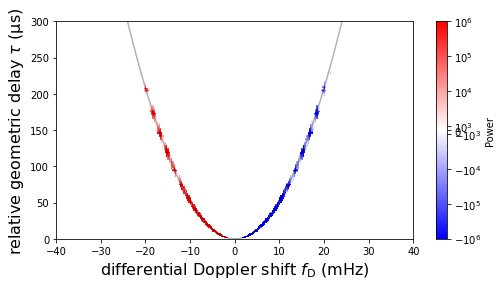

/tmp/ipykernel_2612671/3711518689.py:52: RuntimeWarning: Mean of empty slice
  r1 = np.nanmean(np.real( ccs )[np.where(tau >= 0)]*mask1[np.where(tau >= 0)],axis=0)
/tmp/ipykernel_2612671/3711518689.py:53: RuntimeWarning: Mean of empty slice
  i1 = np.nanmean(np.imag( ccs )[np.where(tau >= 0)]*mask1[np.where(tau >= 0)],axis=0)


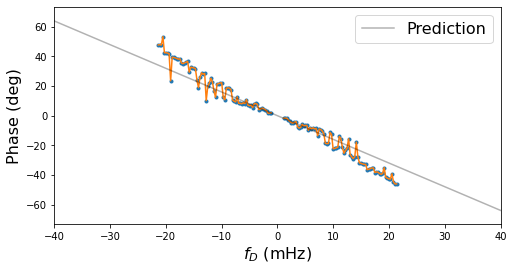

In [23]:


tau_tol = 0.5
tau_sel_max = 230
tau_sel_min = 0.9

ylimit = 300
xlimit = 40

#put an orientation, curvature and veff for the prediction
screenOrientation = xi1_slider.val*u.deg 
screenOrientation =  ( np.arctan(sig1  ).to(u.deg) + xi1_slider.val*u.deg - 90 * u.deg)
screenOrientation = ( -np.arctan(sig1  ).to(u.deg) + xi1_slider.val*u.deg - 180 * u.deg)
eta = eta_int1
vveff = diveff1


#make a mask to get a phase gradient surrounding the curvature value
grid = np.meshgrid(fd,tau)
mask1 = np.ones(grid[0].shape)
mask1[np.sqrt(grid[1]/eta)<np.abs(grid[0])-tau_tol*u.mHz] = np.nan
mask1[np.sqrt(grid[1]/eta)>np.abs(grid[0])+tau_tol*u.mHz] = np.nan
mask1[np.abs(grid[1]) > tau_sel_max * u.us] = np.nan
mask1[np.abs(grid[1]) < tau_sel_min * u.us] = np.nan
#mask cross spectrum
masked_A = np.ma.masked_invalid(np.angle( ccs ) * 180 / np.pi * mask1)

plt.figure(  figsize=(8., 4.)  )

plt.imshow( masked_A  * np.real(ccs) ,
           origin='lower', aspect='auto', interpolation='none',
           cmap = 'bwr',
           extent=axis_extent(fd, tau),
           norm=SymLogNorm(vmin=-1e6, vmax=1e6, linthresh = 1e4))

plt.xlim(-xlimit, xlimit)
plt.ylim(0., ylimit)
plt.xlabel(r"differential Doppler shift $f_\mathrm{{D}}$ "
           rf"({fd.unit.to_string('latex')})", fontsize = 16)
plt.ylabel(r"relative geometric delay $\tau$ "
           rf"({tau.unit.to_string('latex')})", fontsize = 16)

cbar = plt.colorbar()
cbar.set_label('Power')

plt.plot(fd, (fd**2 * eta).to(u.us), alpha = 0.3, c = 'k' ) 
plt.show()

%matplotlib inline

plt.figure(  figsize=(8., 4.)  )

n1 = np.nansum(mask1,axis=0)
r1 = np.nanmean(np.real( ccs )[np.where(tau >= 0)]*mask1[np.where(tau >= 0)],axis=0)
i1 = np.nanmean(np.imag( ccs )[np.where(tau >= 0)]*mask1[np.where(tau >= 0)],axis=0)
phi1 = np.angle( (r1+1j*i1)  )
# phi1_err = circstd(np.angle(S01)*mask1,axis=0,nan_policy='omit',high=np.pi,low=-np.pi)/np.sqrt(n1)


plt.plot(fd, phi1 * 180 / np.pi, '.')
plt.plot(fd, phi1 * 180 / np.pi)

plt.xlabel('$f_D$ (mHz)', fontsize = 16)
plt.ylabel('Phase (deg)', fontsize = 16)

#setting the maxim extent to plot phase gradients
ylim = np.nanmax( phi1 * 180 / np.pi ) + 20
plt.ylim(-ylim,ylim)
plt.xlim(-xlimit,xlimit)


b_v = ( uvw['AO'] - uvw['GB'] )
b_v = np.array([b_v.x.value, b_v.y.value, b_v.z.value]) * b_v.x.unit

b_mag = np.sqrt( b_v[1]**2 +  b_v[2]**2 )
ang_b =  np.arctan2( b_v[1], b_v[2])

prediction = (2 * np.pi * b_mag * np.cos( screenOrientation - ang_b) / vveff ).to(u.s)


plt.plot(fd, ( fd * (prediction) * u.rad ).to(u.deg), label = 'Prediction', alpha = 0.3, c = 'k')

plt.legend(fontsize = 16)



## Phase gradients for screen 2 and case II

In [24]:
scr1_init = 0.1
scr2_init = 3.0

In [26]:
timer2 = timer.time()

#set the pulsar position, distance, proper motion, as well as velocity and orientation on the sky
pulsar_params = "8h37m05.6485930s", "6d10m16.06361s", d_p, PMRA, PMDEC, vpsr_init, dp_angle_init 

#set screen 1 and screen 2 distance, orientation and velocity
scr1_params = d_s1_init, xi1_init, v1_init 
scr2_params = d_s2_init, xi2_init, v2_init 


obs0, obs1, obs2, obs12, los_fac = observations(xi1=xi1_init, v1=v1_init,
                                                 xi2=xi2_init, v2=v2_init,
                                                 vpsr=vpsr_init, dp_angle=dp_angle_init,
                                                 scr1_scale = scr1_init, scr2_scale = scr2_init,
                                                 d_s1 = d_s1_init, d_s2 = d_s2_init, 
                                                 Amp1 = Amp1_init, Amp2 = Amp2_init,
                                                 sig1 = sig1_init, sig2 = sig2_init,
                                                 shift1 = shift1_init, shift2 = shift2_init,
                                                 N1 = N1, N2 = N2,
                                                 d_p = d_p, vearth = vearth, e_angle = e_angle
                                               )
all_obs = obs0, obs1, obs2, obs12
brightness = np.hstack([obs.brightness.ravel() * los_fac for obs in all_obs])
mall = np.abs(brightness)

#compute the visibilities, and baselines
spectra, uvw, wavefields = int_vlbi(pulsar_params, 
                                       time, freq, dishes,
                                       scr1_params,
                                         scr2_params,
                                         N1 = N1, N2 = N2,
                                         Amp1 = Amp1_init, Amp2 = Amp2_init,
                                         sig1 = sig1_init, sig2 = sig2_init,
                                         scr1_scale = scr1_init, scr2_scale = scr2_init,
                                         shift1 = shift1_init, shift2 = shift2_init, mag_mult = 1.)

print('Time: ', timer.time() - timer2)


#compute geometric factors related to the 2-screen geometry
deff_int_1, deff_int_2, veff_int_1, veff_int_2, sig1, sig2, gam1, gam2  = interaction_geometric_factors(d_p = d_p, 
                                        vpsr = vpsr_init, 
                                        dp_angle = dp_angle_init, 
                                        vearth = vearth, 
                                        e_angle = e_angle, 
                                        ds1 = d_s1_init, 
                                        xi1 = xi1_init, 
                                        v1 = v1_init, 
                                        ds2 = d_s2_init, 
                                        xi2 = xi2_init, 
                                        v2 = v2_init, 
                                        freq = np.mean(freq))

#getting a curvature for the first screen
eta1, ddeff1, dveff1 = screen_1d_curvature(d_p = d_p, 
                    vpsr = vpsr_init, 
                    dp_angle = dp_angle_init, 
                    vearth = vearth, 
                    e_angle = e_angle, 
                    ds1 = d_s1_init, 
                    xi1 = xi1_init, 
                    v1 = v1_init, 
                    freq = np.mean(freq),
                    extra_info = True)


#getting a curvature for the second screen
eta2, ddeff2, dveff2 = screen_1d_curvature(d_p = d_p, 
                    vpsr = vpsr_init, 
                    dp_angle = dp_angle_init, 
                    vearth = vearth, 
                    e_angle = e_angle, 
                    ds1 = d_s2_init, 
                    xi1 = xi2_init, 
                    v1 = v2_init, 
                    freq = np.mean(freq),
                    extra_info = True)

#compute curvatures for case i and ii 
eta_int1, eta_int2, _, _, diveff1, diveff2  = interaction_arcs(d_p = d_p, 
                                        vpsr = vpsr_init, 
                                        dp_angle = dp_angle_init, 
                                        vearth = vearth, 
                                        e_angle = e_angle, 
                                        ds1 = d_s1_init, 
                                        xi1 = xi1_init, 
                                        v1 = v1_init, 
                                        ds2 = d_s2_init, 
                                        xi2 = xi2_init, 
                                        v2 = v2_init, 
                                        freq = np.mean(freq))

Time:  18.75314950942993


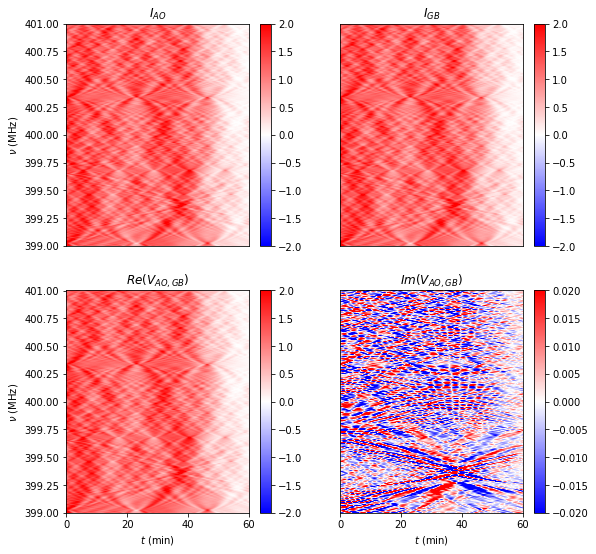

In [27]:
names = list(dishes)

disp_lim = 2.

imshow_kwargs = dict(origin='lower', aspect='auto', cmap='bwr',
                     extent=axis_extent((time-time[0]).to(u.min), freq))

grid = plt.GridSpec(nrows=2, ncols=2)
plt.figure(figsize=(9, 9))


for i in range(2):
    plt.subplot(grid[0, i])
    plt.imshow(spectra[names[i], names[i]].real / np.mean(np.abs(spectra[names[i], names[i]])), 
               vmin=-disp_lim, vmax=disp_lim, **imshow_kwargs)
    plt.xticks([])
    plt.title(rf'$I_{{{names[i]}}}$')
    plt.colorbar()
    if i<1:
        plt.ylabel(r'$\nu~\left(\rm{MHz}\right)$')
    else:
        plt.yticks([])
    
    
for i in range(2):
    plt.subplot(grid[1, i])
    
    if i ==0:
        spec = spectra[names[0], names[1]].real / np.mean(spectra[names[0], names[1]].real)
        mult = 1.
        plt.ylabel(r'$\nu~\left(\rm{MHz}\right)$')
        plt.title(rf'$Re\left(V_{{{names[0]},{names[1]}}}\right)$')
        
    else:
        spec = spectra[names[0], names[1]].imag  
        mult = 1e-2
        plt.yticks([])
        plt.title(rf'$Im\left(V_{{{names[0]},{names[1]}}}\right)$')
        
    plt.imshow(spec, 
               vmin=-disp_lim*mult, vmax=disp_lim*mult, **imshow_kwargs)

    plt.xlabel(r'$t~\left(\rm{min}\right)$')
    
    plt.colorbar()

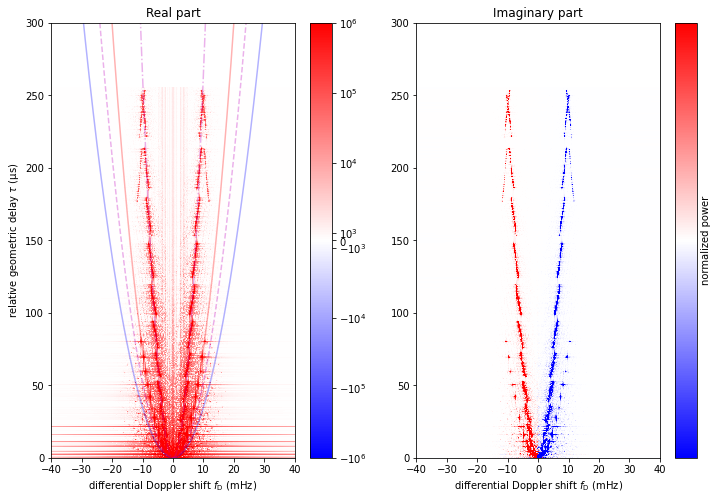

In [28]:
conjspec00 = np.fft.fftshift(np.fft.fft2(spectra[names[0], names[1]]))
conjspec11 = np.roll(np.roll(np.fliplr(np.flipud(conjspec00)),1,0),1,1)



cs0 = np.fft.fftshift(np.fft.fft2(spectra[names[0], names[0]].real -spectra[names[0], names[0]].real.mean()))
cs1 = np.fft.fftshift(np.fft.fft2(spectra[names[1], names[1]].real -spectra[names[1], names[1]].real.mean()))
ccs = cs0*np.conjugate(cs1)

tau = np.fft.fftshift(np.fft.fftfreq(freq.size, freq[1]-freq[0])).to(u.us)
fd = np.fft.fftshift(np.fft.fftfreq((time-time[0]).to(u.min).size, 
                                    (time-time[0]).to(u.min)[1]-(time-time[0]).to(u.min)[0])).to(u.mHz)


ylimit = 300
xlimit = 40


plt.figure(  figsize=(12., 8.)  )


plt.subplot(121)
plt.imshow( np.real( ccs ),
           origin='lower', aspect='auto', interpolation='none',
           extent=axis_extent(fd, tau), cmap='bwr',
           norm=SymLogNorm(vmin=-1e6, vmax=1e6, linthresh = 1e4))

# plt.xlim(-20., 20.)
# plt.ylim(0., 40.)
plt.xlabel(r"differential Doppler shift $f_\mathrm{{D}}$ "
           rf"({fd.unit.to_string('latex')})")
plt.ylabel(r"relative geometric delay $\tau$ "
           rf"({tau.unit.to_string('latex')})")


cbar = plt.colorbar()
plt.title('Real part')

plt.plot(( taudot_arr * np.mean(freq) ).to(u.mHz) , (( taudot_arr * np.mean(freq) ).to(u.mHz)**2 * eta1).to(u.us), c = 'b', alpha = 0.3 , label = 'Curvature scr 1')
plt.plot(( taudot_arr * np.mean(freq) ).to(u.mHz) , (( taudot_arr * np.mean(freq) ).to(u.mHz)**2 * eta2).to(u.us), c = 'r', alpha = 0.3 , label = 'Curvature scr 2')

#interaction arc curvature for case I
plt.plot(( taudot_arr * np.mean(freq) ).to(u.mHz) , (( taudot_arr * np.mean(freq) ).to(u.mHz)**2 * eta_int1).to(u.us), '--' ,c = 'm', alpha = 0.3, label = 'Interaction curvature case I'  )
#interaction arc curvature for case II
plt.plot(( taudot_arr * np.mean(freq) ).to(u.mHz) , (( taudot_arr * np.mean(freq) ).to(u.mHz)**2 * eta_int2).to(u.us), '-.' ,c = 'm', alpha = 0.3, label = 'Interaction curvature case II'  )





plt.ylim(-0.,ylimit)
plt.xlim(-xlimit,xlimit)



plt.subplot(122)


plt.imshow( np.imag( ccs ),
           origin='lower', aspect='auto', interpolation='none',
           extent=axis_extent(fd, tau), cmap='bwr',
           norm=SymLogNorm(vmin=-1e5, vmax=1e5, linthresh = 1e5))

# plt.xlim(-20., 20.)
# plt.ylim(0., 40.)
plt.xlabel(r"differential Doppler shift $f_\mathrm{{D}}$ "
           rf"({fd.unit.to_string('latex')})")
plt.title('Imaginary part')

cbar = plt.colorbar()
cbar.set_label('normalized power')

plt.ylim(-0.,ylimit)
plt.xlim(-xlimit,xlimit)

plt.show()

## Phase gradients for screen 2

/cita/modules/python/3.10.2/lib/python3.10/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


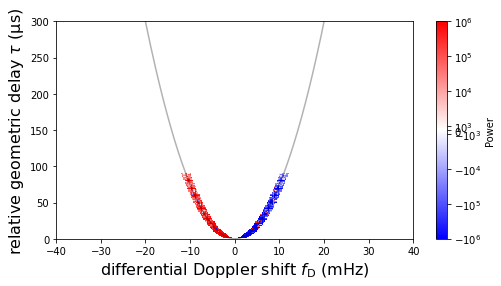

/tmp/ipykernel_2612671/1287329546.py:50: RuntimeWarning: Mean of empty slice
  r1 = np.nanmean(np.real( ccs )[np.where(tau >= 0)]*mask1[np.where(tau >= 0)],axis=0)
/tmp/ipykernel_2612671/1287329546.py:51: RuntimeWarning: Mean of empty slice
  i1 = np.nanmean(np.imag( ccs )[np.where(tau >= 0)]*mask1[np.where(tau >= 0)],axis=0)


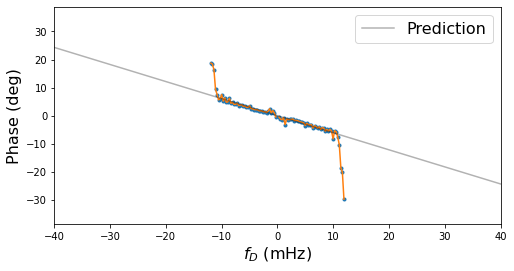

In [29]:


tau_tol = 1.
tau_sel_max = 90
tau_sel_min = 0.9

ylimit = 300
xlimit = 40

#put an orientation, curvature and veff for the prediction
screenOrientation = xi2_slider.val*u.deg 
eta = eta2
vveff = dveff2


#make a mask to get a phase gradient surrounding the curvature value
grid = np.meshgrid(fd,tau)
mask1 = np.ones(grid[0].shape)
mask1[np.sqrt(grid[1]/eta)<np.abs(grid[0])-tau_tol*u.mHz] = np.nan
mask1[np.sqrt(grid[1]/eta)>np.abs(grid[0])+tau_tol*u.mHz] = np.nan
mask1[np.abs(grid[1]) > tau_sel_max * u.us] = np.nan
mask1[np.abs(grid[1]) < tau_sel_min * u.us] = np.nan
#mask cross spectrum
masked_A = np.ma.masked_invalid(np.angle( ccs ) * 180 / np.pi * mask1)

plt.figure(  figsize=(8., 4.)  )

plt.imshow( masked_A  * np.real(ccs) ,
           origin='lower', aspect='auto', interpolation='none',
           cmap = 'bwr',
           extent=axis_extent(fd, tau),
           norm=SymLogNorm(vmin=-1e6, vmax=1e6, linthresh = 1e4))

plt.xlim(-xlimit, xlimit)
plt.ylim(0., ylimit)
plt.xlabel(r"differential Doppler shift $f_\mathrm{{D}}$ "
           rf"({fd.unit.to_string('latex')})", fontsize = 16)
plt.ylabel(r"relative geometric delay $\tau$ "
           rf"({tau.unit.to_string('latex')})", fontsize = 16)

cbar = plt.colorbar()
cbar.set_label('Power')

plt.plot(fd, (fd**2 * eta).to(u.us), alpha = 0.3, c = 'k' ) 
plt.show()

%matplotlib inline

plt.figure(  figsize=(8., 4.)  )

n1 = np.nansum(mask1,axis=0)
r1 = np.nanmean(np.real( ccs )[np.where(tau >= 0)]*mask1[np.where(tau >= 0)],axis=0)
i1 = np.nanmean(np.imag( ccs )[np.where(tau >= 0)]*mask1[np.where(tau >= 0)],axis=0)
phi1 = np.angle( (r1+1j*i1)  )
# phi1_err = circstd(np.angle(S01)*mask1,axis=0,nan_policy='omit',high=np.pi,low=-np.pi)/np.sqrt(n1)


plt.plot(fd, phi1 * 180 / np.pi, '.')
plt.plot(fd, phi1 * 180 / np.pi)

plt.xlabel('$f_D$ (mHz)', fontsize = 16)
plt.ylabel('Phase (deg)', fontsize = 16)

#setting the maxim extent to plot phase gradients
ylim = np.nanmax( phi1 * 180 / np.pi ) + 20
plt.ylim(-ylim,ylim)
plt.xlim(-xlimit,xlimit)


b_v = ( uvw['AO'] - uvw['GB'] )
b_v = np.array([b_v.x.value, b_v.y.value, b_v.z.value]) * b_v.x.unit

b_mag = np.sqrt( b_v[1]**2 +  b_v[2]**2 )
ang_b =  np.arctan2( b_v[1], b_v[2])

prediction = (2 * np.pi * b_mag * np.cos( screenOrientation - ang_b) / vveff ).to(u.s)


plt.plot(fd, ( fd * (prediction) * u.rad ).to(u.deg), label = 'Prediction', alpha = 0.3, c = 'k')

plt.legend(fontsize = 16)




## Phase gradients for case II

/cita/modules/python/3.10.2/lib/python3.10/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


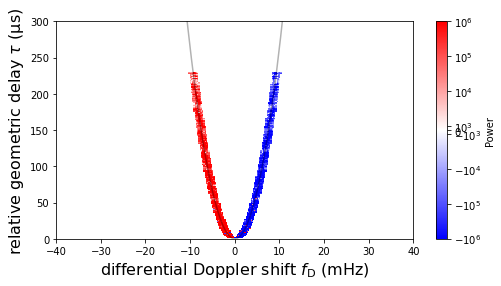

/tmp/ipykernel_2612671/4061136691.py:50: RuntimeWarning: Mean of empty slice
  r1 = np.nanmean(np.real( ccs )[np.where(tau >= 0)]*mask1[np.where(tau >= 0)],axis=0)
/tmp/ipykernel_2612671/4061136691.py:51: RuntimeWarning: Mean of empty slice
  i1 = np.nanmean(np.imag( ccs )[np.where(tau >= 0)]*mask1[np.where(tau >= 0)],axis=0)


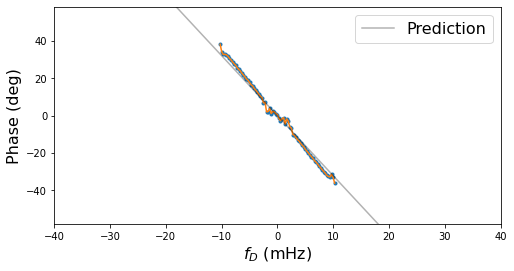

In [30]:


tau_tol = 1
tau_sel_max = 230
tau_sel_min = 0.9

ylimit = 300
xlimit = 40

#put an orientation, curvature and veff for the prediction
screenOrientation = xi1_slider.val*u.deg + 90 * u.deg
eta = eta_int2
vveff = diveff2


#make a mask to get a phase gradient surrounding the curvature value
grid = np.meshgrid(fd,tau)
mask1 = np.ones(grid[0].shape)
mask1[np.sqrt(grid[1]/eta)<np.abs(grid[0])-tau_tol*u.mHz] = np.nan
mask1[np.sqrt(grid[1]/eta)>np.abs(grid[0])+tau_tol*u.mHz] = np.nan
mask1[np.abs(grid[1]) > tau_sel_max * u.us] = np.nan
mask1[np.abs(grid[1]) < tau_sel_min * u.us] = np.nan
#mask cross spectrum
masked_A = np.ma.masked_invalid(np.angle( ccs ) * 180 / np.pi * mask1)

plt.figure(  figsize=(8., 4.)  )

plt.imshow( masked_A  * np.real(ccs) ,
           origin='lower', aspect='auto', interpolation='none',
           cmap = 'bwr',
           extent=axis_extent(fd, tau),
           norm=SymLogNorm(vmin=-1e6, vmax=1e6, linthresh = 1e4))

plt.xlim(-xlimit, xlimit)
plt.ylim(0., ylimit)
plt.xlabel(r"differential Doppler shift $f_\mathrm{{D}}$ "
           rf"({fd.unit.to_string('latex')})", fontsize = 16)
plt.ylabel(r"relative geometric delay $\tau$ "
           rf"({tau.unit.to_string('latex')})", fontsize = 16)

cbar = plt.colorbar()
cbar.set_label('Power')

plt.plot(fd, (fd**2 * eta).to(u.us), alpha = 0.3, c = 'k' ) 
plt.show()

%matplotlib inline

plt.figure(  figsize=(8., 4.)  )

n1 = np.nansum(mask1,axis=0)
r1 = np.nanmean(np.real( ccs )[np.where(tau >= 0)]*mask1[np.where(tau >= 0)],axis=0)
i1 = np.nanmean(np.imag( ccs )[np.where(tau >= 0)]*mask1[np.where(tau >= 0)],axis=0)
phi1 = np.angle( (r1+1j*i1)  )
# phi1_err = circstd(np.angle(S01)*mask1,axis=0,nan_policy='omit',high=np.pi,low=-np.pi)/np.sqrt(n1)


plt.plot(fd, phi1 * 180 / np.pi, '.')
plt.plot(fd, phi1 * 180 / np.pi)

plt.xlabel('$f_D$ (mHz)', fontsize = 16)
plt.ylabel('Phase (deg)', fontsize = 16)

#setting the maxim extent to plot phase gradients
ylim = np.nanmax( phi1 * 180 / np.pi ) + 20
plt.ylim(-ylim,ylim)
plt.xlim(-xlimit,xlimit)


b_v = ( uvw['AO'] - uvw['GB'] )
b_v = np.array([b_v.x.value, b_v.y.value, b_v.z.value]) * b_v.x.unit

b_mag = np.sqrt( b_v[1]**2 +  b_v[2]**2 )
ang_b =  np.arctan2( b_v[1], b_v[2])

prediction = (2 * np.pi * b_mag * np.cos( screenOrientation - ang_b) / vveff ).to(u.s)


plt.plot(fd, ( fd * (prediction) * u.rad ).to(u.deg), label = 'Prediction', alpha = 0.3, c = 'k')

plt.legend(fontsize = 16)



## Visualize baselines

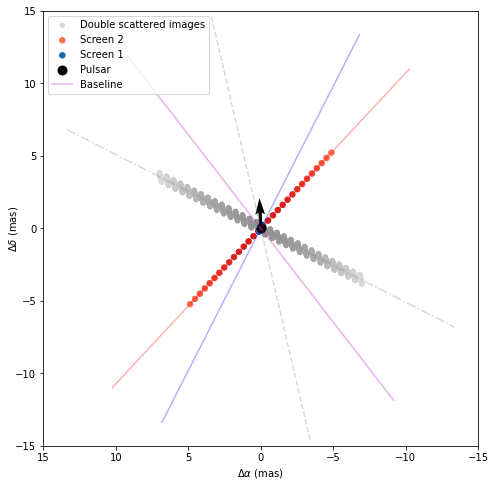

In [32]:
fig, ax_sky = plt.subplots(figsize=(8., 8.))

#set axis scale in mas
mas_ratio = 15
au_fac = u.mas.to(u.rad) * d_s2_init.to(u.AU).value

ax_sky.set_xlim(mas_ratio, -mas_ratio)
ax_sky.set_ylim(-mas_ratio, mas_ratio)
ax_sky.set_aspect("equal")
ax_sky.set_xlabel(r"$\Delta\alpha$ (mas)")
ax_sky.set_ylabel(r"$\Delta\delta$ (mas)", labelpad=-5)


scs = []
skys = []
# Reverse order so non-interaction points plotted on top.
for obs, (taus, taudots, theta_ray), marker, size, cmap, labels in zip(
        all_obs[::-1],
        get_plot_data(all_obs)[::-1],
        "oooo",
        (20, 30, 30, 80),
        ("Greys", "Reds", "Blues", "Greys"),
        ("Double scattered images", "Screen 2", "Screen 1", "Pulsar")
):

    sky = ax_sky.scatter(*theta_ray, marker=marker, s=size,
                             c=np.abs(obs.brightness), cmap=cmap,
                             norm=LogNorm(vmin=mall.min()*0.1, vmax=mall.max() ), label = labels)
    skys.insert(0, sky)
    
#plot velocity direction of the pulsar (also trace a path of its velocity for the next N=10 days)
pul_pos = obs0.source.vel * 10 * u.day
ax_sky.quiver( obs0.pos.x.to_value(u.AU) / au_fac, obs0.pos.y.to_value(u.AU) / au_fac,
                pul_pos.x.to_value(u.AU) / au_fac, pul_pos.y.to_value(u.AU) / au_fac,
                color='k',
                linewidth = 10,
              angles='xy',
              scale_units='xy',
                scale=1
          )




ang_u = xi1_slider.val*u.deg
x_or = np.array([ -mas_ratio, mas_ratio]) * np.sin(ang_u)
y_or = np.array([ -mas_ratio, mas_ratio]) * np.cos(ang_u)

plt.plot( x_or, y_or, c = 'b', alpha = 0.3)


ang_u = xi2_slider.val*u.deg
x_or = np.array([ -mas_ratio, mas_ratio]) * np.sin(ang_u)
y_or = np.array([ -mas_ratio, mas_ratio]) * np.cos(ang_u)

plt.plot( x_or, y_or, c = 'r', alpha = 0.3)



ang_u = -np.arctan(sig1  ).to(u.deg) + xi1_slider.val*u.deg
x_or = np.array([ -mas_ratio, mas_ratio]) * np.sin(ang_u)
y_or = np.array([ -mas_ratio, mas_ratio]) * np.cos(ang_u)

plt.plot( x_or, y_or, c = 'gray', alpha = 0.3, ls = '--')


ang_u =  xi1_slider.val*u.deg + 90 * u.deg
x_or = np.array([ -mas_ratio, mas_ratio]) * np.sin(ang_u)
y_or = np.array([ -mas_ratio, mas_ratio]) * np.cos(ang_u)

plt.plot( x_or, y_or, c = 'gray', alpha = 0.3, ls = '-.')




ang_u =  np.arctan2( b_v[1], b_v[2])

x_or = np.array([ -mas_ratio, mas_ratio]) * np.sin(ang_u)
y_or = np.array([ -mas_ratio, mas_ratio]) * np.cos(ang_u)

plt.plot( x_or, y_or, c = 'm', alpha = 0.3, label = 'Baseline')





ax_sky.legend()
